# Bayesian linear regression - pt 2

We will explore more expressive guides and exact inference

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch 
import seaborn as sns

import pyro
import pyro.distributions as dist
from torch.distributions import constraints

Use same data as the previous notebook

In [2]:
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")

We will focus on `cont_africa`, `rugged`, and `rgdppc_2000`.

In [3]:
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]

We log transform GDP because it is highly skewed

In [4]:
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

In [5]:
train = torch.tensor(df.values, dtype=torch.float)

## Model

In [6]:
def model(is_cont_africa, ruggedness, log_gdp):
    a = pyro.sample("a", dist.Normal(0., 10.))
    b_a = pyro.sample("bA", dist.Normal(0., 1.))
    b_r = pyro.sample("bR", dist.Normal(0., 1.))
    b_ar = pyro.sample("bAR", dist.Normal(0., 1.))
    sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness
    with pyro.plate("data", len(ruggedness)):
        pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)

Define the variational family:

In [7]:
def guide(is_cont_africa, ruggedness, log_gdp):
    a_loc = pyro.param('a_loc', torch.tensor(0.))
    a_scale = pyro.param('a_scale', torch.tensor(1.), constraint=constraints.positive)
    sigma_loc = pyro.param('sigma_loc', torch.tensor(1.), constraint=constraints.positive)
    weights_loc = pyro.param('weights_loc', torch.randn(3))
    weights_scale = pyro.param('weights_scale', torch.ones(3), constraint=constraints.positive)
    a = pyro.sample("a", dist.Normal(a_loc, a_scale))
    b_a = pyro.sample("bA", dist.Normal(weights_loc[0], weights_scale[0]))
    b_r = pyro.sample("bR", dist.Normal(weights_loc[1], weights_scale[1]))
    b_ar = pyro.sample("bAR", dist.Normal(weights_loc[2], weights_scale[2]))
    sigma = pyro.sample("sigma", dist.Normal(sigma_loc, torch.tensor(0.05)))
    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness

## Inference with SVI

In [8]:
from pyro.infer import SVI, Trace_ELBO
import pyro.optim as optim
import logging
logging.basicConfig(format='%(message)s', level=logging.INFO)

In [9]:
pyro.set_rng_seed(1)

In [10]:
svi = SVI(model, guide, optim.Adam({'lr':0.05}), loss=Trace_ELBO())

In [11]:
is_cont_africa, ruggedness, log_gdp = train[:, 0], train[:, 1], train[:, 2]

In [12]:
pyro.clear_param_store()
num_iters = 5000
for i in range(num_iters):
    elbo = svi.step(is_cont_africa, ruggedness, log_gdp)
    if i % 500 == 0:
        logging.info(f"Elbo loss: {elbo}")

Elbo loss: 5795.468078792095
Elbo loss: 415.81697630882263
Elbo loss: 250.71917808055878
Elbo loss: 247.19455885887146
Elbo loss: 249.2003738284111
Elbo loss: 250.9648449420929
Elbo loss: 249.350925385952
Elbo loss: 248.78312557935715
Elbo loss: 248.62143713235855
Elbo loss: 250.42745751142502


## Posterior summary

In [13]:
from pyro.infer import Predictive

In [15]:
num_samples = 1000
predictive = Predictive(model, guide=guide, num_samples=num_samples)
svi_samples = {k: v.reshape(num_samples).detach().cpu().numpy()
               for k, v in predictive(log_gdp, is_cont_africa, ruggedness).items()
               if k != "obs"}

In [18]:
pd.DataFrame(svi_samples).describe()

,a,bA,bR,bAR,sigma
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,9.177020,-1.890622,-0.157847,0.304515,0.902898
std,0.059607,0.122805,0.039538,0.067683,0.047971
min,8.981010,-2.326312,-0.273225,0.094186,0.740845
25%,9.140463,-1.979107,-0.183673,0.259464,0.870317
50%,9.178211,-1.887476,-0.157873,0.304908,0.901982
75%,9.217098,-1.803683,-0.133102,0.348932,0.935171
max,9.369950,-1.408436,-0.021295,0.511624,1.043846


## Exact inference with HMC

In [20]:
from pyro.infer import MCMC, NUTS

In [21]:
nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)
mcmc.run(is_cont_africa, ruggedness, log_gdp)

Sample: 100%|████████████████████████████████████████| 1200/1200 [00:33, 35.33it/s, step size=4.73e-01, acc. prob=0.920]


In [22]:
hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

In [23]:
pd.DataFrame(hmc_samples).describe()

,a,bA,bAR,bR,sigma
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,9.179546,-1.832929,0.342208,-0.182088,0.954808
std,0.136310,0.235240,0.129034,0.074199,0.054706
min,8.711738,-2.577808,-0.029275,-0.431558,0.812028
25%,9.092796,-1.983383,0.251245,-0.232334,0.916038
50%,9.182643,-1.837151,0.343096,-0.183790,0.949730
75%,9.272237,-1.681208,0.428025,-0.134868,0.989015
max,9.605078,-1.167123,0.788349,0.080034,1.130312


## Comparing SVI to exact inference

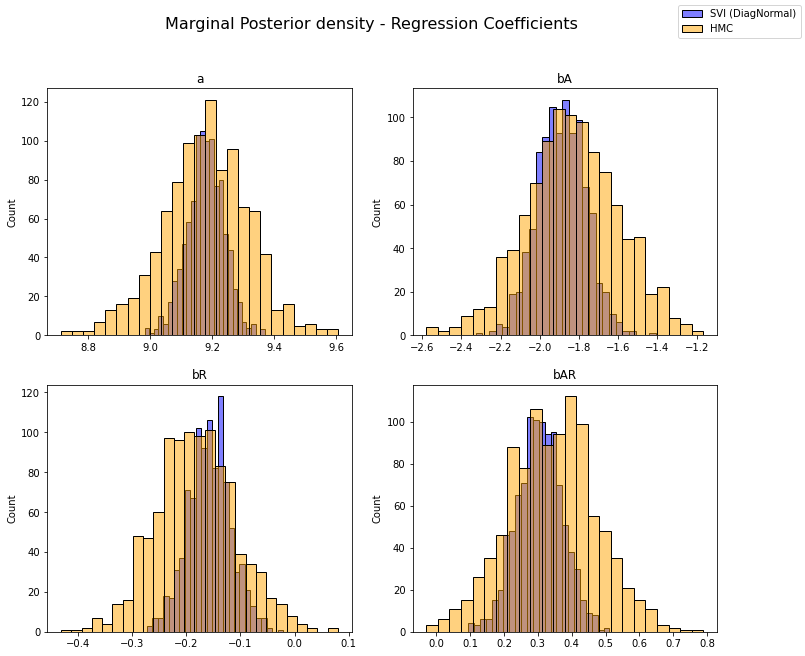

In [28]:
sites = ["a", "bA", "bR", "bAR", "sigma"]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    site = sites[i]
    sns.histplot(svi_samples[site], ax=ax, label="SVI (DiagNormal)", color='blue', alpha=0.5)
    sns.histplot(hmc_samples[site], ax=ax, label="HMC", color='orange', alpha=0.5)
    ax.set_title(site)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

We see that SVI quite severely underestimates the variance for this variational family.

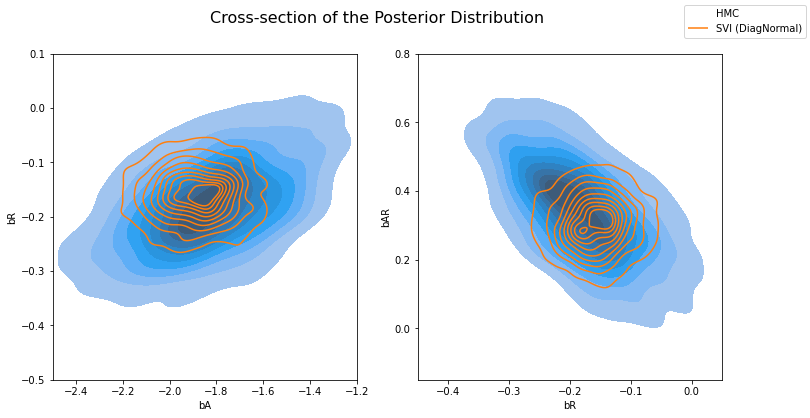

In [30]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Cross-section of the Posterior Distribution", fontsize=16)
sns.kdeplot(x=hmc_samples["bA"], y=hmc_samples["bR"], ax=axs[0], shade=True, label="HMC")
sns.kdeplot(x=svi_samples["bA"], y=svi_samples["bR"], ax=axs[0], label="SVI (DiagNormal)")
axs[0].set(xlabel="bA", ylabel="bR", xlim=(-2.5, -1.2), ylim=(-0.5, 0.1))
sns.kdeplot(x=hmc_samples["bR"], y=hmc_samples["bAR"], ax=axs[1], shade=True, label="HMC")
sns.kdeplot(x=svi_samples["bR"], y=svi_samples["bAR"], ax=axs[1], label="SVI (DiagNormal)")
axs[1].set(xlabel="bR", ylabel="bAR", xlim=(-0.45, 0.05), ylim=(-0.15, 0.8))
handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

This variational family is not good at picking up on correlations in the posterior distribution

## Multivariate normal guides

We don't have to use a jointly independent (mean field) variational family. Pyro has in-built MultiVariateNormal guides, which can help with picking up on parameter correlations.

In [31]:
from pyro.infer.autoguide import AutoMultivariateNormal, init_to_mean

In [32]:
guide = AutoMultivariateNormal(model, init_loc_fn=init_to_mean)

In [34]:
svi = SVI(model, guide, optim.Adam({'lr':0.01}), loss=Trace_ELBO())

In [35]:
is_cont_africa, ruggedness, log_gdp = train[:, 0], train[:, 1], train[:, 2]

In [36]:
pyro.clear_param_store()
for i in range(num_iters):
    elbo = svi.step(is_cont_africa, ruggedness, log_gdp)
    if i % 500 == 0:
        logging.info(f"Elbo loss: {elbo}")

Elbo loss: 703.2962011098862
Elbo loss: 420.50198435783386
Elbo loss: 250.7025689482689
Elbo loss: 249.8654989004135
Elbo loss: 249.30760949850082
Elbo loss: 247.30142492055893
Elbo loss: 249.7928325533867
Elbo loss: 247.20394849777222
Elbo loss: 248.54042530059814
Elbo loss: 249.66331708431244


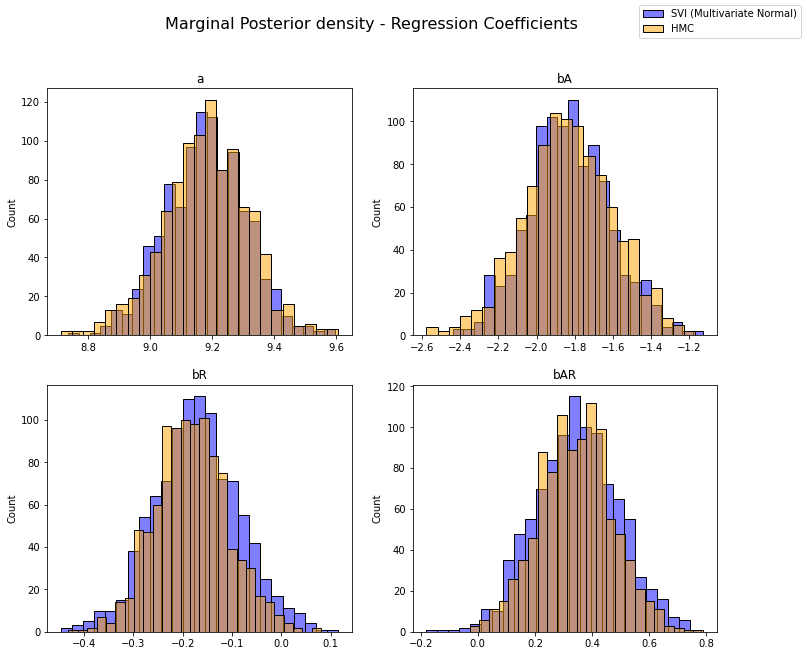

In [37]:
predictive = Predictive(model, guide=guide, num_samples=num_samples)
svi_mvn_samples = {k: v.reshape(num_samples).detach().cpu().numpy()
                   for k, v in predictive(log_gdp, is_cont_africa, ruggedness).items()
                   if k != "obs"}
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    site = sites[i]
    sns.histplot(svi_mvn_samples[site], ax=ax, label="SVI (Multivariate Normal)", color='blue', alpha=0.5)
    sns.histplot(hmc_samples[site], ax=ax, label="HMC", color='orange', alpha=0.5)
    ax.set_title(site)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

Much closer to the true posterior

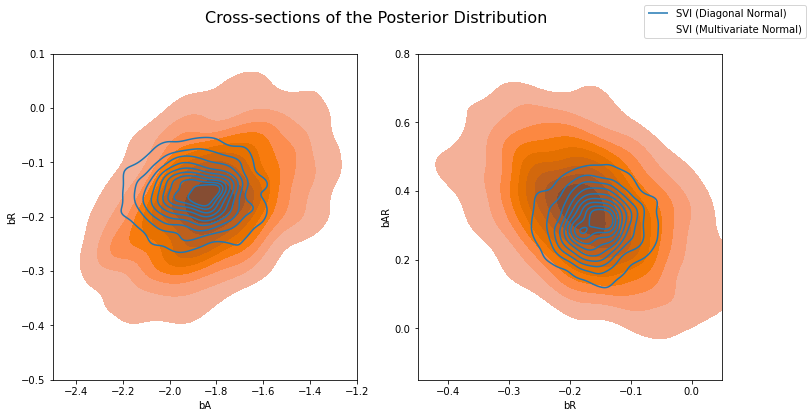

In [39]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Cross-sections of the Posterior Distribution", fontsize=16)
sns.kdeplot(x=svi_samples["bA"], y=svi_samples["bR"], ax=axs[0], label="SVI (Diagonal Normal)")
sns.kdeplot(x=svi_mvn_samples["bA"], y=svi_mvn_samples["bR"], ax=axs[0], shade=True, label="SVI (Multivariate Normal)")
axs[0].set(xlabel="bA", ylabel="bR", xlim=(-2.5, -1.2), ylim=(-0.5, 0.1))
sns.kdeplot(x=svi_samples["bR"], y=svi_samples["bAR"], ax=axs[1], label="SVI (Diagonal Normal)")
sns.kdeplot(x=svi_mvn_samples["bR"], y=svi_mvn_samples["bAR"], ax=axs[1], shade=True, label="SVI (Multivariate Normal)")
axs[1].set(xlabel="bR", ylabel="bAR", xlim=(-0.45, 0.05), ylim=(-0.15, 0.8))
handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

The MVN guide is much more dispersed than the mean field guide

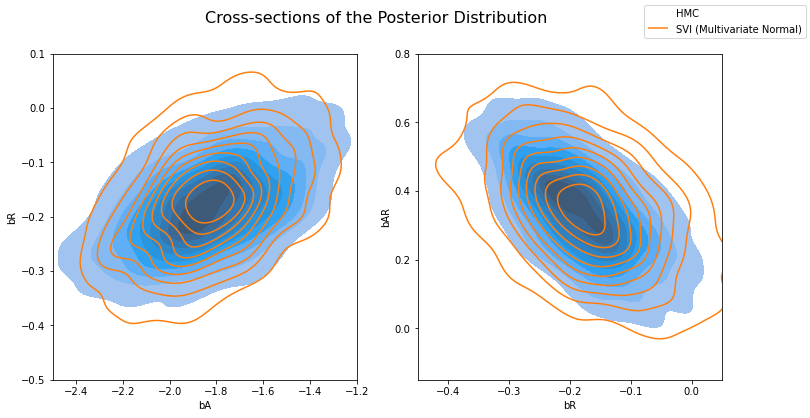

In [41]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Cross-sections of the Posterior Distribution", fontsize=16)
sns.kdeplot(x=hmc_samples["bA"], y=hmc_samples["bR"], ax=axs[0], shade=True, label="HMC")
sns.kdeplot(x=svi_mvn_samples["bA"], y=svi_mvn_samples["bR"], ax=axs[0], label="SVI (Multivariate Normal)")
axs[0].set(xlabel="bA", ylabel="bR", xlim=(-2.5, -1.2), ylim=(-0.5, 0.1))
sns.kdeplot(x=hmc_samples["bR"], y=hmc_samples["bAR"], ax=axs[1], shade=True, label="HMC")
sns.kdeplot(x=svi_mvn_samples["bR"], y=svi_mvn_samples["bAR"], ax=axs[1], label="SVI (Multivariate Normal)")
axs[1].set(xlabel="bR", ylabel="bAR", xlim=(-0.45, 0.05), ylim=(-0.15, 0.8))
handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

and better captures the posterior